# Quantum Kernel Methods

## Introduction

Parametrized quantum circuits are perhaps the most important models for quantum machine learning algorithms in the NISQ era. Due their direct analogy with classical neural networks they are sometimes called "Quantum Neural networks" at their root they are nothing more than variatonal ansatz in terms of quantum gates rather than parametrized functions [1](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) , by that sense one could think of the textbook application of the variational method as kind of neural network as well.

Mathematically, parametrized circuits are a lot closer to classical kernel methods, which are a different kind of classical machine learning [2](https://arxiv.org/abs/2101.11020) . Drawing inspiration from classical kernel methods, quantum kernel methods are a fresh take at how to approach a variety of machine learning problems (mainly in classification), these methods have received a lot of attention in the quantum machine learning community [3-5]

In this tutorial, we will very briefly introduce quantum kernel methods 

# Crash Course on Kernel methods

In classical machine learning, you can  "intuitively" think of Kernel methods as inverse principal component analysis. Instead of reducing the dimensionality of your data, you will embed it into a higher-dimensional space (feature space) where you can use linear methods to analyze non-linear characteristics of the data. As shown in the figure, one can map 1D data into a 2D space and in this new 2D space the feature vectors of the original  data are linearly separable (You can separate them by drawing a line or a plane in higher dimensions)

![](kernel_method.png)



# Wait, Increasing dimensionality seems like a bad idea 🤔!

Indeed, in practice datasets maybe large, so we don't actually want to create those new feature vectors directly (the $y$ in the previous slide), the genious of kernel methods comes from the idea that we can analyze these feature vectors by only accessing their inner products in feature space, which we denote as $K(,)$ usually called kernel function (rather than augmenting my space I run functions on individual vectors of my data)

$$K(x_{i},x_{j}) = \phi(x_{j})^{T}\phi(x_{i})$$

The Kernel matrix is the matrix whose elements are gicen by the kernel function
applied on the different pairs $K_{i,j}=K(x_{i},x_{j})$

In order to build up some intuituin let us discuss support vector machines next

# Support vector machines in 5 minutes

## Linear separability

In 2 dimensions we can separate the data by a line. The equation for a line is 
$$y =  a x +b$$

Let us rename $x=x_{1}$ and $y=x_{2}$  then one may write

$$a x_{1}-x_{2} + b =0$$

if we let $\vec{x}=(x_{1},x_{2})$ and $W= (a,-1)$ then we can write

$$W^{T} \vec{x} + b =0$$

Which is the equation of a hyperplane, all we need to find is adequate $W$ to find the line (Hyperplane) that separates the data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import  make_moons, make_circles # as a task use make moons instead :)
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from matplotlib.cm import coolwarm

In [2]:
x=np.linspace(0,10,120)
np.random.seed(42)
y=np.array([i+ 5*np.random.rand() if i>5 else 4.2*np.random.rand() for i in x])

In [3]:
X = np.column_stack((x, y))
W = np.array([-1, 0])
b = 10
W2 = np.array([-1.2, 0])
b2 = 11

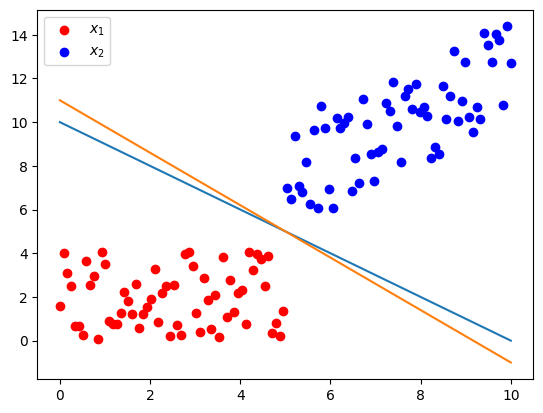

In [4]:
plt.scatter(x[:len(x)//2],y[:len(x)//2 ],color='red',label=r"$x_{1}$")
plt.scatter(x[(len(x)//2):],y[(len(x)//2):],color='blue',label=r"$x_{2}$")
plt.plot(x,W.T@X.T +b)
plt.plot(x,W2.T@X.T +b2)
plt.legend()

We find the optimal $\mathbf{W}$ by solving the optimization problem 

\begin{align*}
    &\text{minimize} \quad \frac{1}{2} \|\mathbf{W}\|^2 \\
    &\text{subject to} \quad y_i(\mathbf{W}^T\mathbf{x}_i + b) \ge 1, \quad \forall i=1, \dots, n
\end{align*}

Where the labels for the  two classes (blue and red in the previous plots)
are $y_{i}={-1,1}$. The samples on the margin are called support vectors. To 
classify points we just need to consider that points on top of the line such 
that
$$W^{T} \vec{x} + b =C$$
have the label $y=1$ while points bellow the line 
$$W^{T} \vec{x} + b =-C$$
Since $W^{T} \vec{x}$ is the inner product of the vectors $W$ and $x$ we can 
write our classifier as 

$$y_{pred} = sign(\langle W,x \rangle + b)$$

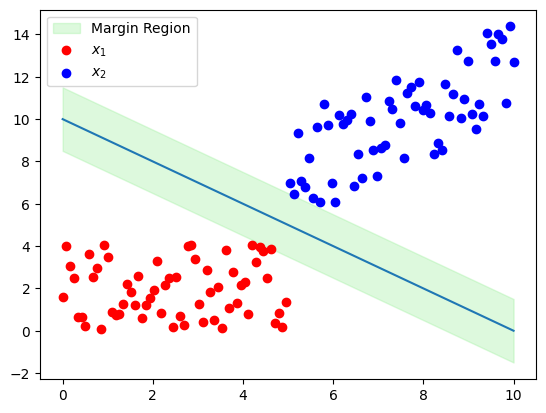

In [5]:
margin=1.5 
plt.plot(x,W.T@X.T +b)
plt.fill_between(x,W.T@X.T +b -margin, W.T@X.T +b +margin, color='lightgreen', alpha=0.3, label='Margin Region')
plt.scatter(x[:len(x)//2],y[:len(x)//2 ],color='red',label=r"$x_{1}$")
plt.scatter(x[(len(x)//2):],y[(len(x)//2):],color='blue',label=r"$x_{2}$")
plt.legend()

# Back to how not to increase the data 🤔!

Let us denote the hyperplane in feature space with ($W',b'$). We can rewrite 
the vector defining the hyperplane as $W' = \sum_{i}\alpha_{i} y_{i}$, after some 
algebra this would yield the predictor 
$$y_{pred}(x_{j}) = sign( \sum_{i}\alpha_{i}^{optimal} K(x_{i},x_{j}) + b')$$

So we Only need the Kernel to make predictions. But wait, this still doesn't tell me
why I don't increase the data or how this is useful!

The key insight comes from the fact that we can often find an explicit formula
for the kernel, which allows us to bypass the embedding $U$ which can potentially
be expensive to compute and store

For example the feature map 

$$\phi(x_1, x_2) = (x_1,x_2, e^{- [x_1^2 + x_2^2]  })$$

Results in the kernel 

$$K(x,y) = x_{1} y_{1} + x_{2} y_{2} +  e^{-[x_1^2 + x_2^2 + y_1^2 + y_2^2 ]}$$

Even if you can't find the analytical expression, it is still useful to write it
this way as you no longer need to store extra features but simply apply a function
in your original ones

# Quantum Kernels in 5 minutes

Given what we have covered so far understanding the idea behind Quantum kernel 
methods is easy, we simply want to estimate the kernel function (Kernel matrix)
Using a quantum circuit [7].

The first step we need to take is to encode our data into a quantum state 
$\ket{\phi(x)}$. To do this we will use an ``encoding" circuit which we will 
call $U$. Such that 

$$U(x) | 0^{\otimes N} \rangle = | \phi(x) \rangle.$$

There is an on going debate as to how to do this best, in this tutorial we will
use Angle encoding (feel free to change the data encoding method), regardless 
of which method you use you can think about it as just taking your classical 
data onto the Hilbert space, once they are in Hilbert space, we usually call them 
quantum feature vectors. Once we have encoded our data we can simply 
construct the Kernel matrix from the inner products of quantum feature vectors 
in Hilbert space

$$K^Q_{ij} = |\langle \phi(\mathbf{x}_j) | \phi(\mathbf{x}_i) \rangle |^2$$

We do a quantum circuit simulation per each element of the matrix

PS: Data encoding circuits are variational circuits that's where the connection
to QML comes from (see [8] for slightly longer technical explanation)

# A Slight Detour Data encoding:

To use a quantum algorithm, classical data must somehow be brought into a quantum circuit. This is usually referred to as data encoding. There are many ways one can go about it, some of the most popular ways are:

- Basis Encoding
- Amplitude Encoding
- **Angle Encoding**
- Phase Encoding

For a more detailed discussion [see the corresponding IBM Quantum platform section](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning/data-encoding)

# Basis Encoding

Suppose the fourth entry of our dataset is $x_{4}=(5,7)$ then to encode this into 
a quantum circuit using basis encoding, we write the binarey representation in 
the computational basis, namely

1. We express the numbers as binary strings $x_{4}=(101,111)$
2. We prepare an equal superposition of the states that compose the feature vector
namely we prepare 

$$\ket{x_{4}} = \frac{1}{\sqrt{2}} (\ket{101}+\ket{111})$$

# Amplitude Encoding

We keep the same example, but this time we encode the data into the amplitudes 
of the state vector.

1. We find the normalization constant $\alpha=\sqrt{5^{2}+7^{2}} =\sqrt{74} $
2. We prepare a state in the computational basis which amplitude corresponds to
our encoding (We use the numbers from 0 to the number of elements in our
feauture vector as the basis)

$$\ket{x_{4}} = \frac{1}{\sqrt{74}} (5\ket{0}+7\ket{1})$$

## Angle Encoding

In angle encoding the data is represented by applying rotations onto the computational basis

To encode a feature vector we prepare the state

$$\ket{\vec{x}} = \bigotimes_{k=1}^{N} \left(cos(x_{k}) \ket{0} + sin(x_{k})\ket{1}\right) = \bigotimes_{k=1}^{N} R_{y}(2 x_{k}) \ket{0}$$



### Phase encoding

Phase encoding is similar to angle encoding, for this one it is advised to rescale your data to be in the range $(0,2\pi]$ 

Just like we applied rotations in each individual qubit before for angle encoding, for phase encoding we apply the phase gate

$$\ket{\vec{x}} = \bigotimes_{k=1}^{N} P_{k}(\phi=x_{k}) \ket{+}^{\otimes N} = \frac{1}{\sqrt{2^{N}}}\bigotimes_{k=1}^{N} (\ket{0}+e^{i x_{k}}\ket{1})$$


# What does the actual circuit looks like?

Let us again consider the kernel matrix

$$K^Q_{ij} = |\langle \phi(\mathbf{x}_j) | \phi(\mathbf{x}_i) \rangle |^2$$

And rewrite it a little bit, let us recall that 

$$U(x) | 0^{\otimes N} \rangle = | \phi(x) \rangle.$$

Substituting the latter into the former yields

$$ K^Q_{ij}=  |\langle 0^{\otimes N} | U^\dagger(\mathbf{x}_j) U(\mathbf{x}_i) | 0^{\otimes N} \rangle |^2
$$

So the state we need to prepare in the circuit is 

$$\ket{\psi} = U^\dagger(\mathbf{x}_j) U(\mathbf{x}_i) | 0^{\otimes N} \rangle$$

and the probablility of observing the output $| 0^{\otimes N} \rangle$ will 
give us our kernel matrix entry.


This way of constructing quantum kernels is known as Quantum Kernel Estimation (QKE) 
and it's what we'll do later in the tutorial. By replacing the Kernel function calculation 
with QKE, we can classify data in this "quantum feature space" with a standard support vector 
machine. 

![](qke.png) 



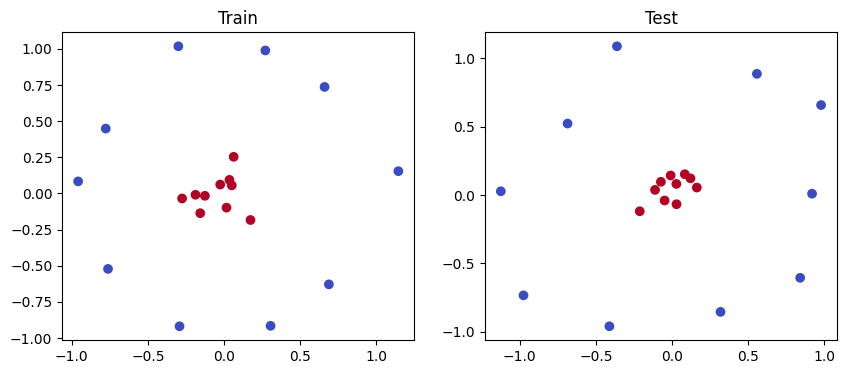

In [6]:
# Generate data set
X_train, y_train = make_circles(20, noise=0.1, factor=0.1, random_state=42) 
#make factor bigger for a challenge
X_test, y_test = make_circles(20, noise=0.1, factor=0.1, random_state=420)

# Visualize respectively the training and testing set
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], 
              marker='o', c = coolwarm(np.array(y_train, dtype=np.float32)))
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[1].scatter(X_test[:,0], X_test[:,1], marker='o', c = coolwarm(np.array(y_test, dtype=np.float32)))
plt.show()

We need as many qubits as features

In [7]:
n_qubits = len(X_train[0])
n_qubits

2

We then construct our circuit (the one one in the picture) with pennylane, for 
ease of simulation. We use pennylanne's expval function which will take an 
operator $OP$ as argument. It will use the state prepared by the circuit

$$\ket{\psi} = U^\dagger(\mathbf{x}_j) U(\mathbf{x}_i) | 0^{\otimes N} \rangle$$

and compute the expectation value of $OP$ namely

$$\bra{\psi}OP\ket{\psi}$$

if we let $OP=| 0^{\otimes N} \rangle \langle  0^{\otimes N} |$. Then the expectation value we'll compute is given by

$$output= \braket{\psi|0}\braket{0|\psi} = |\braket{0|\psi}|^{2}=|\langle  0^{\otimes N} | U^\dagger(\mathbf{x}_j) U(\mathbf{x}_i) | 0^{\otimes N} \rangle |^{2}= K_{ij}^{Q}$$
so we can estimate our kernel elements by computing this expectation value directly

In [8]:
circuit = qml.device("lightning.qubit", wires=n_qubits)

op = np.zeros((2 ** n_qubits, 2 ** n_qubits)) # |0^{n}><0^{n}|
op[0, 0] = 1 # |0^{n}><0^{n}|

@qml.qnode(circuit)
def qke(x1, x2):
    """Circuit for the Quantum Kernel Estimation"""
    AngleEmbedding(x1, wires=range(n_qubits)) # U(x1)
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits)) #U^{\dagger}(x2)
    return qml.expval(qml.Hermitian(op, wires=range(n_qubits))) #K_{i,j}

 We check that our kernel function makes sense, by verifying that 
$K_{i,i}^{Q} =1$

In [9]:
qke(np.array([1. ,1.]), np.array([1., 1.]))

1.0

We then construct the Kernel matrix by iterating through the elements of the 
dataset

In [10]:
def q_kernel_matrix(X1, X2):
    return np.array([[qke(x1, x2) for x2 in X2] for x1 in X1])

We now use a support vector classifier with our QKE and a classical kernel

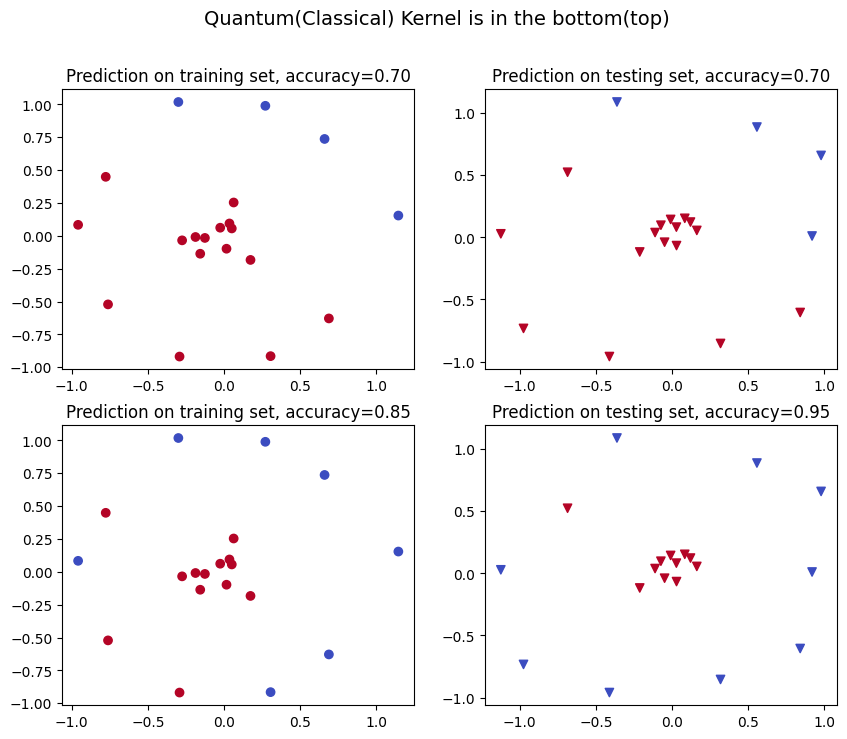

In [11]:
# Create support vector machines
svm_qke = svm.SVC(kernel=q_kernel_matrix)
svmc = svm.SVC(kernel="linear")

# Train the svm with training data
svm_qke.fit(X_train, y_train)
svmc.fit(X_train, y_train)

# See how the svm classifies the training and testing data
predict_svm_qke_train = svm_qke.predict(X_train)
predict_svm_qke_test = svm_qke.predict(X_test)
predict_svm_train = svmc.predict(X_train)
predict_svm_test = svmc.predict(X_test)
# Calculate the accuracy
accuracy_train_qke = np.array(predict_svm_qke_train == y_train, dtype=int).sum()/len(y_train)
accuracy_test_qke = np.array(predict_svm_qke_test == y_test, dtype=int).sum()/len(y_test)
accuracy_train= np.array(predict_svm_train == y_train, dtype=int).sum()/len(y_train)
accuracy_test = np.array(predict_svm_test == y_test, dtype=int).sum()/len(y_test)
fig, ax = plt.subplots(2, 2, figsize=[10, 8])
ax[0,0].scatter(X_train[:,0], X_train[:,1], marker='o', 
              c = coolwarm(np.array(predict_svm_train, dtype=np.float32)))
ax[0,0].set_title('Prediction on training set, accuracy={:.2f}'.format(accuracy_train))
ax[0,1].scatter(X_test[:,0], X_test[:,1], marker='v', 
              c = coolwarm(np.array(predict_svm_test, dtype=np.float32)))
ax[0,1].set_title('Prediction on testing set, accuracy={:.2f}'.format(accuracy_test))
ax[1,0].scatter(X_train[:,0], X_train[:,1], marker='o', 
              c = coolwarm(np.array(predict_svm_qke_train, dtype=np.float32)))
ax[1,0].set_title('Prediction on training set, accuracy={:.2f}'.format(accuracy_train_qke))
ax[1,1].scatter(X_test[:,0], X_test[:,1], marker='v', 
              c = coolwarm(np.array(predict_svm_qke_test, dtype=np.float32)))
ax[1,1].set_title('Prediction on testing set, accuracy={:.2f}'.format(accuracy_test_qke))
fig.suptitle('Quantum(Classical) Kernel is in the bottom(top)', fontsize=14)
plt.show()

The next function just allows us to visualize the decision boundary and its 
margins

In [12]:

# Visualize the decision function, boundary, and margins of +- 0.2
def visualize_decision_bound(clf,qclf):
    XX, YY = np.meshgrid(np.linspace(-1.2, 1.2, 10), 
                         np.linspace(-1.2, 1.2, 10))
    
    # Calculate the decision function value on the 10x10 mesh
    Zq = qclf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z_qke = Zq.reshape(XX.shape)
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z_clas = Z.reshape(XX.shape)
    fig, ax = plt.subplots(1, 2, figsize=[10, 4])

    # visualize the decision function and boundary
    ax[0].contourf(XX, YY, Z_qke ,vmin=-1., vmax=1., levels=20,
                 cmap=coolwarm, alpha=1)
    ax[0].scatter(X_train[:,0], X_train[:,1], 
                c = coolwarm(np.array(y_train, dtype=np.float32)),
               edgecolor='black')
    ax[0].scatter(X_test[:,0], X_test[:,1], marker='v', 
                c = coolwarm(np.array(y_test, dtype=np.float32)),
               edgecolor='black')
    ax[0].contour(XX, YY, Z_qke, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.2, 0, .2])
    ax[1].contourf(XX, YY, Z_clas ,vmin=-1., vmax=1., levels=20,
                 cmap=coolwarm, alpha=1)
    ax[1].scatter(X_train[:,0], X_train[:,1], 
                c = coolwarm(np.array(y_train, dtype=np.float32)),
               edgecolor='black')
    ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', 
                c = coolwarm(np.array(y_test, dtype=np.float32)),
               edgecolor='black')
    ax[1].contour(XX, YY, Z_clas, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.2, 0, .2])
    ax[0].set_title("Quantum Kernel")    
    ax[1].set_title("Classical Kernel")

We finally visualize how our classification looks like for the classical and quantum estimated
kernels

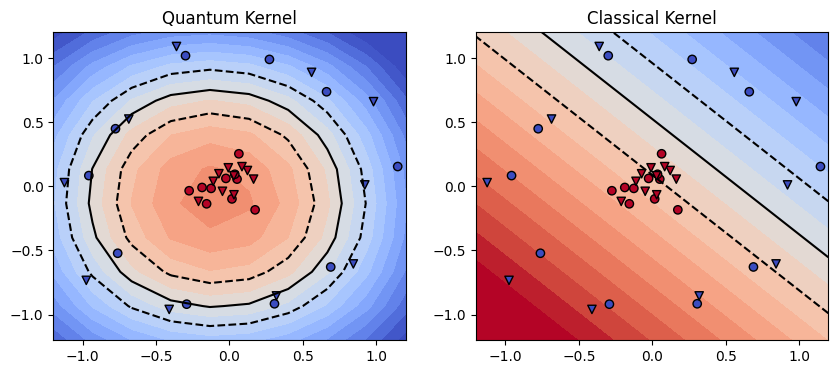

In [13]:
# Visualize the decision function
visualize_decision_bound(svmc,svm_qke)

Based on today's discussion what went wrong with the classical kernel? how do 
we improve it?

**Clue**: Look at the sckit-learn documentation for SVC, you might want to change 
the kernel we used

### References:
1. Variational Method in Quantum mechanics. Wikipedia (I pointed to wikipedia for easy access but I recommend the corresponding section in Sakurai and Napolitano)
2. Supervised quantum machine learning models are kernel methods  https://arxiv.org/abs/2101.11020
3. Quantum machine learning in feature Hilbert spaces https://arxiv.org/abs/1803.07128
4. Covariant quantum kernels for data with group structure https://arxiv.org/abs/2105.03406
5. Learning with Kernels by Bernhard Schölkopf and Alexander J. Smola. MIT Press
6. The Elements of Statistical Learning by Hastie https://hastie.su.domains/ElemStatLearn/ (A bit formal, but a great resource)
7. [Kernel-based training of quantum models with scikit-learn in pennylane demos](https://pennylane.ai/qml/demos/tutorial_kernel_based_training)
8. [Quantum Kernel methods tutorial by the QUAIR group](https://www.quair.group/software/pq/tutorials/machine_learning/qkernel_en)
